<a href="https://colab.research.google.com/github/ManullangJihan/Sea-Surface-Temperature-Analysis/blob/main/Sea_Surface_Temperature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Resolution Analysis of Sea Surface Temperature Data

---

### Content
1. Use dimensionality-reduction and the spatio-temporal SST data to look for the dominant modes in the data set. Interpret what we get out of this analysis.
2. Use a multi-resolution analysis (MRA) to extract meaningful features on different time and space scales.
3. Try to extract the El Nino mode from the system, and try building a predictor for this transient phenomenon.



[Source](https://psl.noaa.gov/data/gridded/data.noaa.oisst.v2.html)

## Import the Data

In [1]:
import netCDF4
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

In [ ]:
from scipy.io import netcdf
import numpy as np

# weekly SST data
temp = netcdf.NetCDFFile("/content/drive/MyDrive/SST_DATA/sst.wkmean.1990-present.nc", 'r').variables 

# land-sea mask 
mask = netcdf.NetCDFFile("/content/drive/MyDrive/SST_DATA/lsmask.nc", 'r').variables['mask'].data[0, :, :]
mask = mask.astype(float)

mask2 = mask.copy()
mask2[mask2 == 0] = np.nan

## Visualize The Data

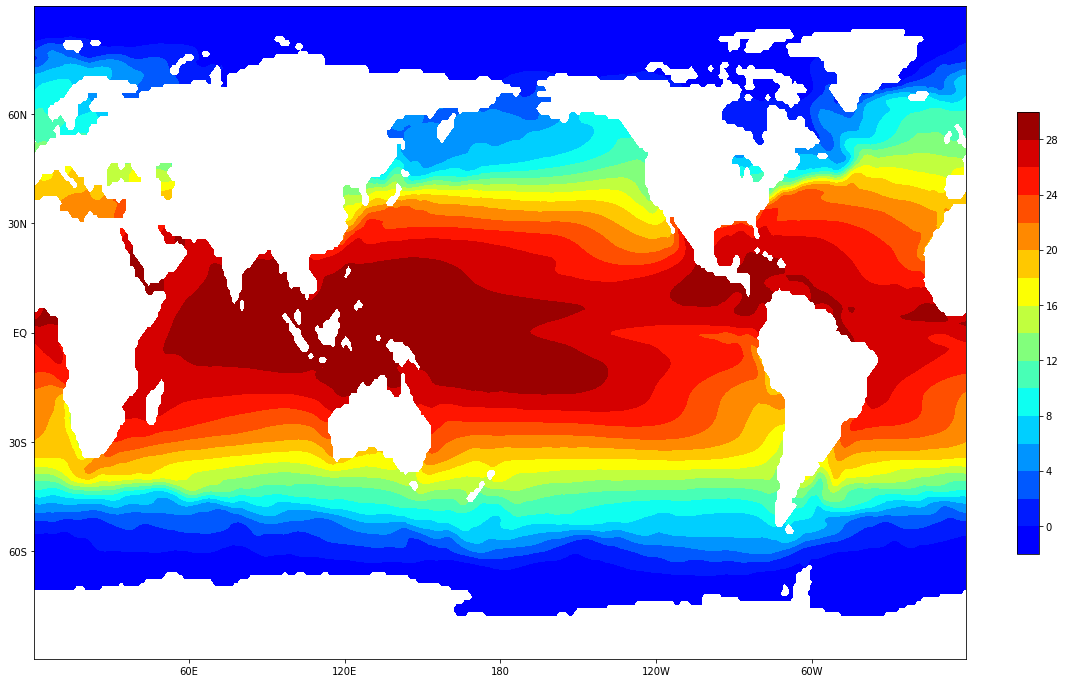

In [3]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

levs = np.arange(16, 29, 0.05)
jet = ["blue", "#007FFF", "cyan","#7FFF7F", "yellow", "#FF7F00", "red", "#7F0000"]
cm = LinearSegmentedColormap.from_list('my_jet', jet, N=len(levs))

fig = plt.figure(figsize = (18, 12))
plt.contourf(temp['lon'].data, temp['lat'].data,
             np.mean(temp['sst'].data, axis = 0) / 100 * mask2,
             levels = 20, vmin = 0, cmap = cm)

plt.xticks(np.arange(60, 350, 60), ['60E', '120E', '180', '120W', '60W'])
plt.yticks(np.arange(-60, 90, 30), ['60S', '30S', 'EQ', '30N', '60N'])
cbar = plt.colorbar(fraction=0.022)
plt.show()

## Extract Meaningful Insight

1. Plot Temperature Average over a year

In [5]:
temp_array = np.array(temp['sst'].data)
n_year = 1455 // 52
temp_avg_year = np.zeros(n_year)
start = 0
end = 52

In [6]:
for i in range(n_year):
    temp_avg = np.mean(temp_array[start:end, mask != 0], axis = 0)
    temp_avg_year[i] = np.mean(temp_avg)
    start = end
    end += 52

In [19]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=np.arange(1, n_year+1),
        y=temp_avg_year / 100,
        mode="markers"
    )
)

fig.update_layout(
    width=700,
    height=550,
    xaxis_title="Year",
    yaxis_title="Average Temperature in Celcius"
)

fig.show()

## SVD

Using Dimensionality Reduction to look for the dominant modes in the data set and interpret what we got out of this analysis

In [20]:
# We will use Dask to calculate svd for big data

import dask
import dask.array as da

dask_array = da.from_array(temp_array)

In [ ]:
def visualize_svd(U, S, V, s_sum):
    n_modes = U.shape[1]
    x = np.arange(1, 10 + 1)
    fig = go.Figure()
    fig.add_trace(
        go.Scatter(
            x = x,
            y = da.diag(S) / np.round(s_sum, 4),
            mode="markers"
        )
    )

    fig.update_layout(
        width=700,
        height=550,
        xaxis_title="Modes",
        yaxis_title=""
    )

    fig.show()

In [22]:
dask_array = np.mean(dask_array, axis=0)
U, S, V = da.linalg.svd(dask_array)

TODO:

- The value of sigma is too small and bad for visualization, find a way to visualize it

In [23]:
r = 10 # Number of modes
U, S, V = da.linalg.svd_compressed(dask_array, k=r)
S = np.diag(S)
new_reduction_data = da.matmul(da.matmul(U,S), V)

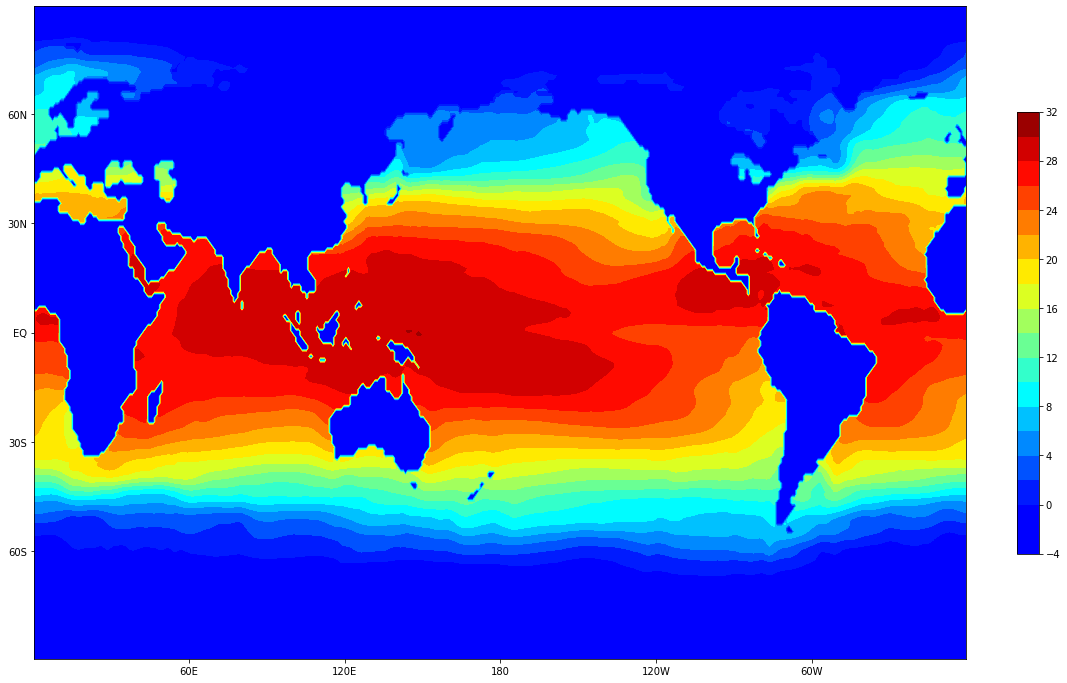

In [30]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

levs = np.arange(16, 29, 0.05)
jet = ["blue", "#007FFF", "cyan","#7FFF7F", "yellow", "#FF7F00", "red", "#7F0000"]
cm = LinearSegmentedColormap.from_list('my_jet', jet, N=len(levs))

fig = plt.figure(figsize = (18, 12))
plt.contourf(temp['lon'].data, temp['lat'].data,
             new_reduction_data / 100 * mask,
             levels = 20, vmin = 0, cmap = cm)

plt.xticks(np.arange(60, 350, 60), ['60E', '120E', '180', '120W', '60W'])
plt.yticks(np.arange(-60, 90, 30), ['60S', '30S', 'EQ', '30N', '60N'])
cbar=plt.colorbar(fraction=0.022)
plt.show()

## Multi-resolution Analysis

- Compare the low frequency and high frequency from multi resolution analysis
- from average image over a decade


In [43]:
# We will compare The results of MRA from two decades

n_decade = 1455 // 52 // 10
temp_avg = np.zeros((n_decade, 180, 360))

for i in range(n_decade):
    temp_avg[i, :] = np.mean(temp_array[:10, :, :], axis=0)

temp_avg = temp_avg.reshape(2, 180, 360)

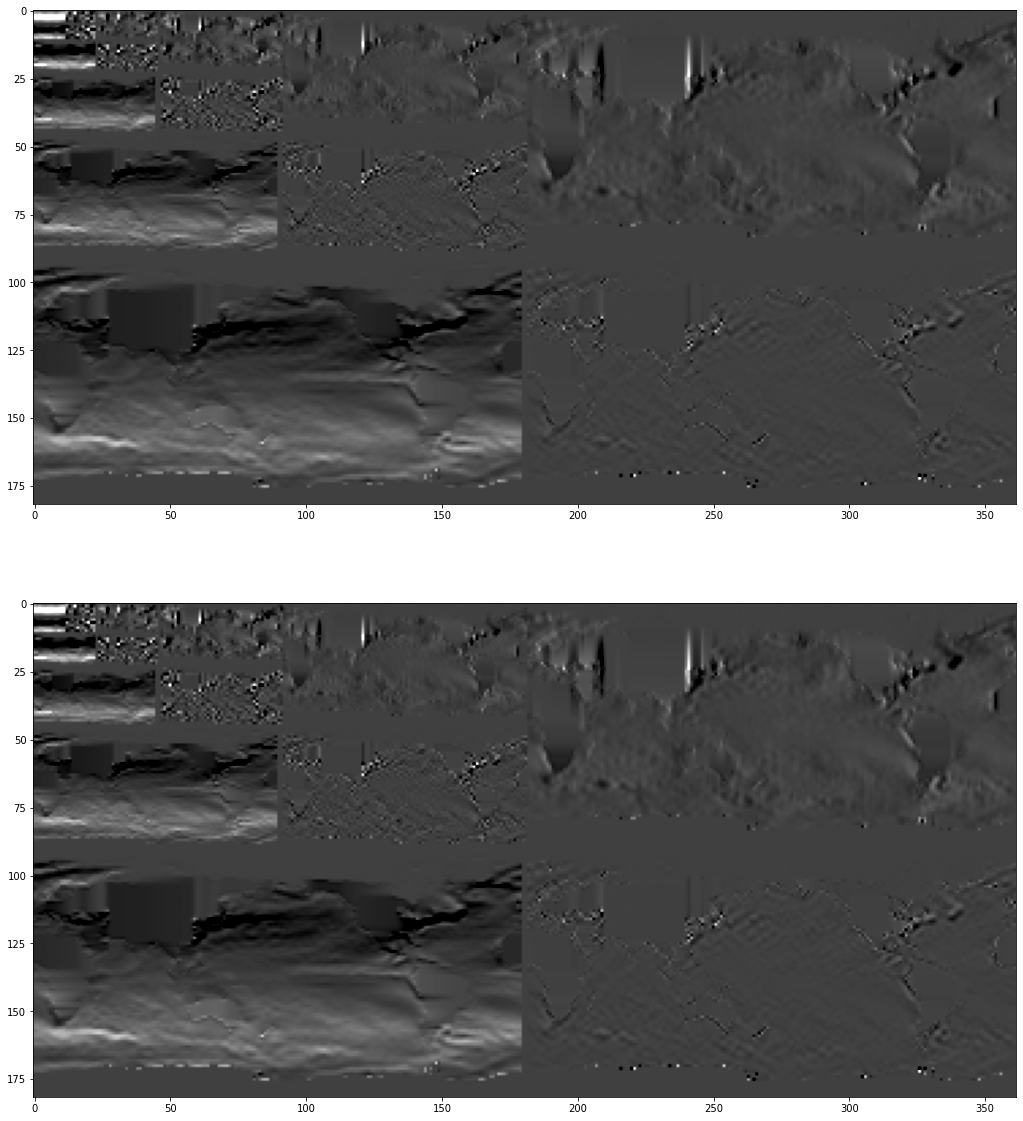

In [44]:
import pywt

fig, axs = plt.subplots(2, 1, figsize=(20, 20))

for i in range(n_decade):
    n = 5
    w = 'db1'
    coeffs = pywt.wavedec2(temp_avg[i, :, :], wavelet=w, level=n)

    # Normalize each coefficient array
    coeffs[0] /= np.abs(coeffs[0]).max()

    for detail_level in range(n):
        coeffs[detail_level + 1] = [d/np.abs(d).max() for d in coeffs[detail_level + 1]]

    arr, coeff_slices = pywt.coeffs_to_array(coeffs)
    axs[i].imshow(arr, cmap="gray", vmin=-0.25, vmax=0.75)


plt.show()

### TODO
---

1. Detect as well as locate abrupt and gradual transitions [Source](https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=0e028124f192f1b56ed09a82a2f4d1b79c17a14d)
2. Multi-resolution video [Source](http://grail.cs.washington.edu/projects/mrvideo/mrvideo.pdf)

